In [1]:
using Plots,LaTeXStrings
default(markersize=3,linewidth=1.5)
using LightGraphs,GraphPlot
using Images,TestImages
using DataFrames,JLD
using LinearAlgebra
#include("FNC.jl");

# Example 7.1.4

Here is the adjacency matrix of a "small-world" network on 200 nodes. Each node is connected to 4 neighbors, and then some edges are randomly changed to distant connections. 

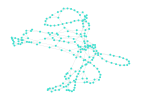

In [2]:
g = watts_strogatz(200,4,0.06)
gplot(g)

The adjacency matrix for this graph reveals the connections as mostly local (i.e., the nonzeros are near the diagonal).

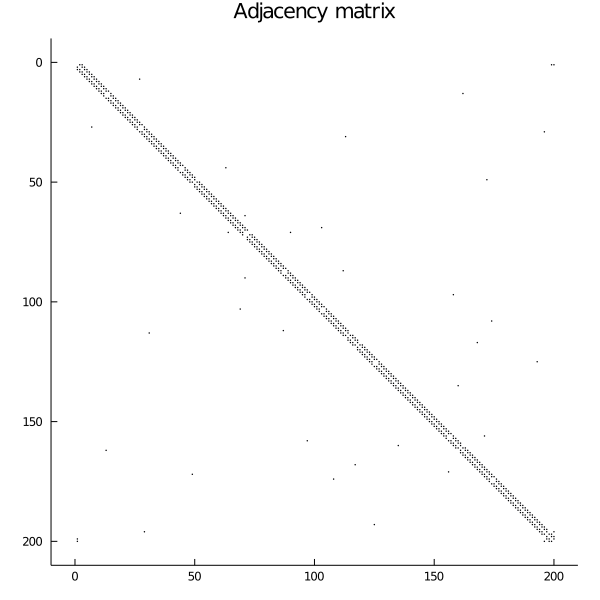

In [3]:
A = adjacency_matrix(g,Float64)
spy(A,m=1,color=:black,title="Adjacency matrix",leg=:none,size=(600,600))
xlims!(-10,210); ylims!(-10,210)

# Example 7.1.5

We will use the `Images` package for working with images. We also load here the `TestImages` package for a large library of well-known standard images.

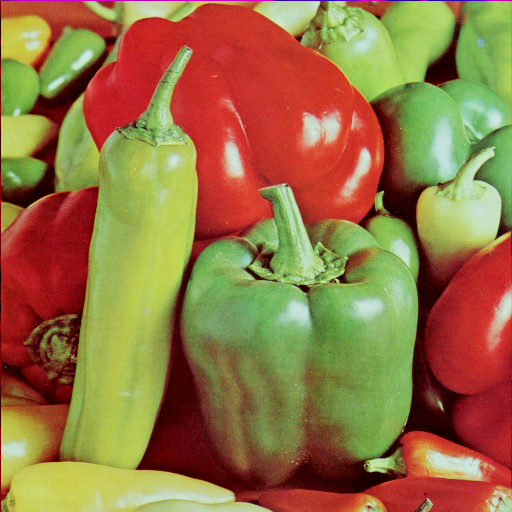

In [4]:
img = testimage("peppers")

The details vary by image type, but for the most part an image is an array of color values.

In [5]:
size(img),eltype(img)

((512, 512), RGB{Normed{UInt8,8}})

The elements here have four values, for red, green, blue, and alpha (opacity). We can convert each of those "planes" into an ordinary matrix.

In [6]:
R = red.(img)
R[1:5,1:5]

5×5 Array{N0f8,2} with eltype Normed{UInt8,8}:
 0.396  0.549  0.592  0.627  0.631
 0.482  0.749  0.745  0.729  0.714
 0.494  0.725  0.725  0.722  0.702
 0.482  0.733  0.729  0.718  0.729
 0.498  0.733  0.714  0.757  0.722

The values above go from zero (no red) to one (full red). It may also be convenient to convert the image to grayscale, which has just one "layer" from zero (black) to one (white). 

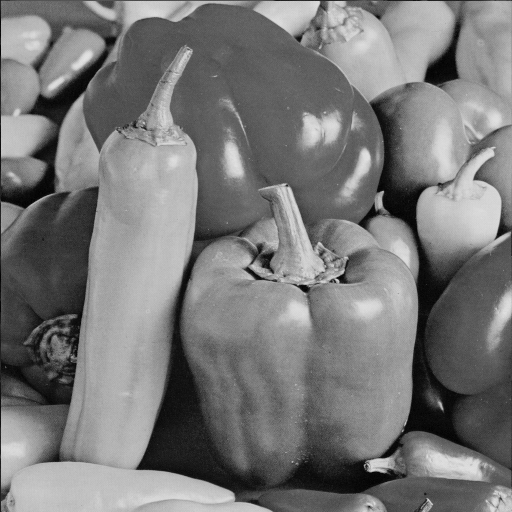

In [7]:
G = Gray.(img)

In [8]:
A = @. gray(Gray(img))
A[1:5,1:5]

5×5 Array{N0f8,2} with eltype Normed{UInt8,8}:
 0.118  0.227  0.243  0.251  0.255
 0.145  0.467  0.447  0.451  0.451
 0.149  0.475  0.451  0.427  0.439
 0.145  0.424  0.475  0.427  0.447
 0.149  0.451  0.486  0.463  0.431

Finally, we can save an image locally for reloading later.

In [9]:
save("peppers.png",Gray.(img))

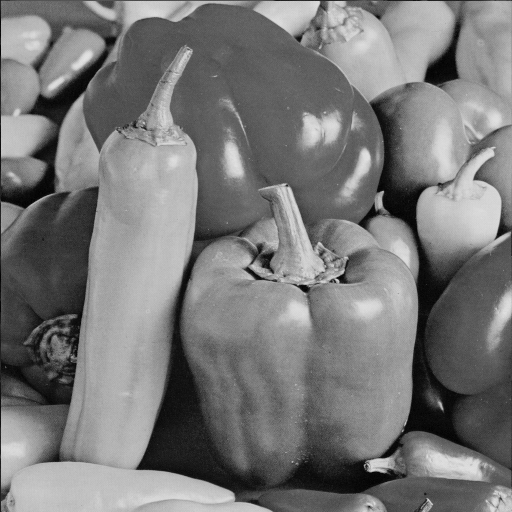

In [10]:
load("peppers.png")

# Example 7.2.1

The `eigvals` command will return just the eigenvalues, as a vector. 

In [11]:
A = pi*ones(2,2)
lambda = eigvals(A)

2-element Array{Float64,1}:
 0.0
 6.283185307179586

If we also want the eigenvectors (returned as the matrix $V$), we use `eigen`.

In [12]:
lambda,V = eigen(A)

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
2-element Array{Float64,1}:
 0.0
 6.283185307179586
vectors:
2×2 Array{Float64,2}:
 -0.707107  0.707107
  0.707107  0.707107

We can check the fact that this is an EVD.

In [13]:
D = diagm(0=>lambda)
opnorm( A - V*D/V )      # "/V" is like "*inv(V)""

8.881784197001252e-16

Even if the matrix is not diagonalizable, `eigen` will run successfully, but the matrix ${V}$ will not be invertible.

In [15]:
lambda,V = eigen([1 1;0 1])

Eigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
2-element Array{Float64,1}:
 1.0
 1.0
vectors:
2×2 Array{Float64,2}:
 1.0  -1.0
 0.0   2.22045e-16

In [16]:
rank(V)

1

# Example 7.2.2

We will confirm the Bauer-Fike theorem on a triangular matrix. These tend to be far from normal. 

In [17]:
n = 15;
lambda = 1:n
A = triu( ones(n)*lambda' );
A[1:5,1:5]

5×5 Array{Float64,2}:
 1.0  2.0  3.0  4.0  5.0
 0.0  2.0  3.0  4.0  5.0
 0.0  0.0  3.0  4.0  5.0
 0.0  0.0  0.0  4.0  5.0
 0.0  0.0  0.0  0.0  5.0

The Bauer-Fike theorem provides an upper bound on the condition number of these eigenvalues.

In [19]:
lambda,V = eigen(A)
@show cond(V);

cond(V) = 7.197767264538044e7


The theorem suggests that eigenvalue changes may be up to 7 orders of magnitude larger than a perturbation to the matrix. A few random experiments show that effects of nearly that size are not hard to observe.

In [20]:
for k = 1:3
    E = randn(n,n);  E = 1e-7*E/opnorm(E);
    mu = eigvals(A+E)
    @show max_change = norm( sort(mu)-lambda, Inf )
end

max_change = norm(sort(mu) - lambda, Inf) = 0.17721666497660848
max_change = norm(sort(mu) - lambda, Inf) = 0.16046591944359
max_change = norm(sort(mu) - lambda, Inf) = 0.08460582896263702


# Example 7.2.3

Let's start with a known set of eigenvalues and an orthogonal eigenvector basis.

In [21]:
D = diagm(0=>[-6,-1,2,4,5])
V,R = qr(randn(5,5))
A = V*D*V';    # note that V' = inv(V)

Now we will take the QR factorization and just reverse the factors.

In [22]:
Q,R = qr(A)
A = R*Q;

It turns out that this is a similarity transformation, so the eigenvalues are unchanged.

In [23]:
sort( eigvals(A) )

5-element Array{Float64,1}:
 -6.0000000000000036
 -0.9999999999999977
  2.0000000000000004
  3.9999999999999982
  4.9999999999999964

What's remarkable is that if we repeat the transformation many times, the process converges to $D$. 

In [24]:
for k = 1:40
    Q,R = qr(A)
    A = R*Q
end
A

5×5 Array{Float64,2}:
 -5.99998      -0.012847      3.65861e-7   -1.7308e-17    1.86698e-15
 -0.012847      4.99998      -0.000250639  -9.73848e-16   9.81005e-16
  3.65861e-7   -0.000250639   4.0          -5.67808e-13  -2.57491e-16
 -1.20416e-19   1.00421e-16  -5.68368e-13   2.0          -1.22837e-12
  1.9655e-31   -2.29467e-28  -1.83005e-24  -1.22844e-12  -1.0

# Example 7.3.2

We verify some of the fundamental SVD properties using the built-in Julia command `svd`.

In [ ]:
A = [i^j for i=1:5, j=0:3]

In [ ]:
U,sigma,V = svd(A);

Note that while the "full" SVD has a square $U$, the "thin" form is the default. Here the columns are orthonormal even though $U$ is not square.

In [ ]:
@show size(U),opnorm(U'*U - I);

In [ ]:
@show size(V),opnorm(V'*V - I);

In [ ]:
sigma

In [ ]:
@show opnorm(A),sigma[1];

In [ ]:
@show cond(A), sigma[1]/sigma[end];

# Example 7.4.1

The following matrix is not hermitian.

In [ ]:
A = [0 2; -2 0]

It has an eigenvalue decomposition with a unitary matrix of eigenvectors, though, so it is normal. 

In [ ]:
lambda,V = eigen(A)
opnorm( V'*V - I )

The eigenvalues are pure imaginary.

In [ ]:
lambda

The singular values are the complex magnitudes of the eigenvalues.

In [ ]:
svdvals(A)

# Example 7.4.2

We construct a real symmetric matrix with known eigenvalues by using the QR factorization to produce a random orthogonal set of eigenvectors. 

In [ ]:
n = 30;
lambda = 1:n 

D = diagm(0=>lambda)
V,R = qr(randn(n,n))   # get a random orthogonal V
A = V*D*V';

The condition number of these eigenvalues is one. Thus the effect on them is bounded by the norm of the perturbation to $A$. 

In [ ]:
for k = 1:3
    E = randn(n,n); E = 1e-4*E/opnorm(E);
    mu = sort(eigvals(A+E))
    @show max_change = norm(mu-lambda,Inf)
end

# Example 7.4.3

We construct a symmetric matrix with a known EVD.

In [ ]:
n = 20;
lambda = 1:n 

D = diagm(0=>lambda)
V,R = qr(randn(n,n))   # get a random orthogonal V
A = V*D*V';

The Rayleigh quotient of an eigenvector is its eigenvalue.

In [ ]:
R = x -> (x'*A*x)/(x'*x);
R(V[:,7])

The Rayleigh quotient's value is much closer to an eigenvalue than its input is to an eigenvector. In this experiment, each additional digit of accuracy in the eigenvector estimate gives two more digits to the eigenvalue estimate.

In [ ]:
delta = @. 1 ./10^(1:4)
quotient = zeros(size(delta))
for (k,delta) = enumerate(delta)
    e = randn(n);  e = delta*e/norm(e);
    x = V[:,7] + e
    quotient[k] = R(x)
end
DataFrame(perturbation=delta,RQminus7=quotient.-7)

# Example 7.5.1

We make an image from some text, then reload it as a matrix.

In [ ]:
plot([],[],leg=:none,annotations=(0.5,0.5,text("Hello world",44,:center,:middle)),
    grid=:none,frame=:none)

In [ ]:
savefig("hello.png")
img = load("hello.png")
A = @. Float64(Gray(img));
@show m,n = size(A);

Next we show that the singular values decrease exponentially, until they reach zero (more precisely, are about $\sigma_1 \varepsilon_\text{mach}$). For all numerical purposes, this determines the rank of the matrix.

In [ ]:
U,sigma,V = svd(A)
scatter(sigma,
    title="Singular values",xaxis=(L"i"), yaxis=(:log10,L"\sigma_i"),leg=:none )

In [ ]:
r = findlast(@.sigma/sigma[1] > 10*eps())

The rapid decrease suggests that we can get fairly good low-rank approximations. 

In [ ]:
Ak = [ U[:,1:k]*diagm(0=>sigma[1:k])*V[:,1:k]' for k=2*(1:4) ]
reshape( [ @.Gray(Ak[i]) for i=1:4 ],2,2)

Consider how little data is needed to reconstruct these images. For rank 8, for instance, we have 8 left and right singular vectors plus 8 singular values, for a compression ratio of better than 25:1.  

In [ ]:
compression = 8*(m+n+1) / (m*n)

# Example 7.5.2

This matrix describes the votes on bills in the 111th session of the United States Senate. (The data set was obtained from voteview.com.) Each row is one senator and each column is a vote item.

In [ ]:
vars = load("voting.jld")
A = vars["A"]
m,n = size(A)

If we visualize the votes (white is "yea," black is "nay," and gray is anything else), we can see great similarity between many rows, reflecting party unity.

In [ ]:
heatmap(A,color=:viridis,
    title="Votes in 111th U.S. Senate",xlabel="bill",ylabel="senator")

We use singular value "energy" to quantify the decay rate of the values. 

In [ ]:
U,sigma,V = svd(A)
tau = cumsum(sigma.^2) / sum(sigma.^2)
scatter(tau[1:16],label="",
    xaxis=("k"), yaxis=(L"\tau_k"), title="Fraction of singular value energy")

The first and second singular triples contain about 58% and 17% respectively of the energy of the matrix. All others have far less effect, suggesting that the information is primarily two-dimensional. The first left and right singular vectors also contain interesting structure.

In [ ]:
scatter( U[:,1],label="",layout=(1,2),
    xlabel="senator" ,title="left singular vector")
scatter!( V[:,1],label="",subplot=2,
    xlabel="bill",title="right singular vector")

Both vectors have values greatly clustered near $\pm C$  for a constant $C$. These can be roughly interpreted as how partisan a particular senator or bill was, and for which political party.   Projecting the senators' vectors into the first two $\V$-coordinates gives a particularly nice way to reduce them to two dimensions. Political scientists label these dimensions "partisanship" and "bipartisanship." Here we color them by actual party affiliation (also given in the data file): red for Republican, blue for Democrat, and yellow for independent. 

In [ ]:
x1 = A*V[:,1];   x2 = A*V[:,2];

Rep = vec(vars["Rep"]); Dem = vec(vars["Dem"]);  Ind = vec(vars["Ind"]);
scatter(x1[Dem],x2[Dem],color=:blue,label="D",
    xaxis=("partisanship"),yaxis=("bipartisanship"),title="111th US Senate in 2D" )
scatter!(x1[Rep],x2[Rep],color=:red,label="R")
scatter!(x1[Ind],x2[Ind],color=:yellow,label="I")